In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sys
import warnings
sys.path.append('..')
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import yaml

C:\Users\applepy\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [109]:
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('bmh')
warnings.filterwarnings("ignore")

Load Artifacts

In [35]:
X_train = pd.read_csv('dataset/X_train.csv', index_col=0, parse_dates=[0])
y_train = pd.read_csv('dataset/y_train.csv', index_col=0, parse_dates=[0])
X_test = pd.read_csv('dataset/X_test.csv', index_col=0, parse_dates=[0])
y_test = pd.read_csv('dataset/y_test.csv', index_col=0, parse_dates=[0])

In [36]:
with open('../config/config.yaml', 'r') as file:
    data_loaded = yaml.safe_load(file)

In [45]:
price = pd.read_csv('../db/raw.csv', index_col=0, header=[0,1], parse_dates=[0])
price_data = price.loc[:, pd.IndexSlice[['Open', 'Close'], ['^GDAXI']]]
# price_data.columns = ['gdaxi']
price_data.columns = ['open', 'close']

In [5]:
data_loaded.keys()

dict_keys(['selected_features', 'threshold', 'xgb_classifier_params'])

Train model

In [6]:
model = xgb.XGBClassifier(**data_loaded['xgb_classifier_params'])

In [7]:
model.fit(X_train[data_loaded['selected_features']], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9560105522288573, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.009593160373648145,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06194041983470603,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=929, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Simplistic Backtest

<Axes: xlabel='Date'>

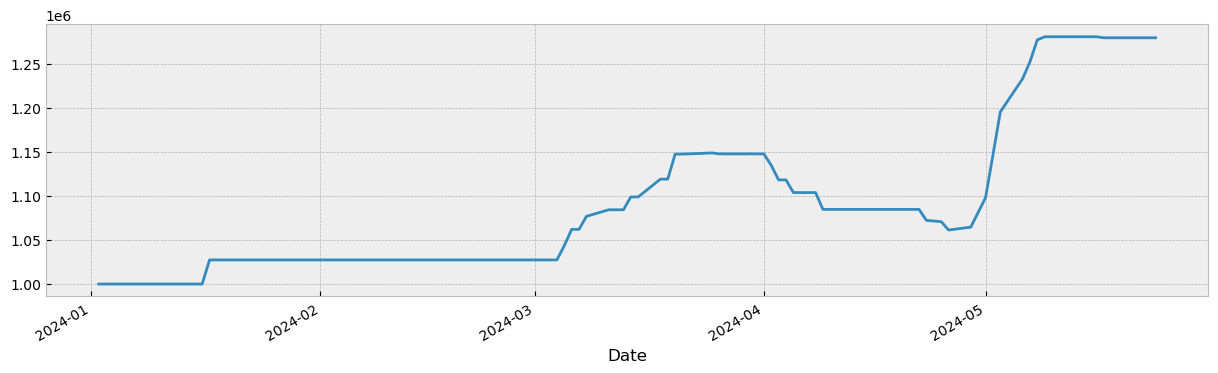

In [111]:
hold_period = 5

backtest = pd.concat([price_data['open'].shift(-1), price_data['close'].shift(hold_period*-1)], axis=1).dropna()

signals = model.predict_proba(X_test[data_loaded['selected_features']])[:, 1] > data_loaded['threshold']
signals = pd.DataFrame(signals, index=X_test.index, columns=['signal']).astype(int)

backtest = backtest.join(signals).dropna()
backtest['returns'] = (backtest['close'] / backtest['open']) * backtest['signal']

backtest.loc[backtest.returns == 0, 'returns'] = 1
backtest.iloc[0,3] = 1000000

backtest.returns.cumprod().plot(figsize=(15, 4))